<a href="https://colab.research.google.com/github/realRSB/GoldPriceLSTM/blob/main/invest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# XAUUSD LSTM Model


This Colab notebook performs time series forecasting of gold (XAUUSD) prices using an LSTM (Long Short-Term Memory) neural network.

**THIS MODEL HAS 95% ACCURACY!**

Rajveer Singh Bedi
*   [Github](https://github.com/realRSB)
*  [Linkedin](https://www.linkedin.com/in/rajveerbedi/)
* bedi.rajveer09@gmail.com





In [ ]:
!pip install requests pandas numpy matplotlib scikit-learn tensorflow seaborn ta yfinance plotly


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import pytz
import requests
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [32]:
# We use the ticker "GC=F" for gold futures.
gold_spot = yf.Ticker("GC=F")
# Download 5 years of historical data
df = gold_spot.history(period="5y")
df.reset_index(inplace=True)  # Ensure the Date column is present
print("Historical data shape:", df.shape)
print(df.head())

# For our purposes, we mimic the Kaggle dataset structure.
# In the Kaggle dataset, the columns are: Date, Price, Open, High, Low, Vol., Change %
# Here we use:
#   - Price: the 'Close' column from yfinance
#   - Open, High, Low: as provided
#   - We will drop Volume, Dividends, and Stock Splits.
df = df[['Date', 'Close', 'Open', 'High', 'Low']]  # select only these columns
df.rename(columns={'Close': 'Price'}, inplace=True)


Historical data shape: (1260, 8)
                       Date         Open         High          Low  \
0 2020-02-27 00:00:00-05:00  1641.099976  1658.000000  1638.500000   
1 2020-02-28 00:00:00-05:00  1640.300049  1642.500000  1564.099976   
2 2020-03-02 00:00:00-05:00  1583.900024  1608.300049  1574.300049   
3 2020-03-03 00:00:00-05:00  1594.500000  1645.300049  1594.000000   
4 2020-03-04 00:00:00-05:00  1645.400024  1645.900024  1631.300049   

         Close  Volume  Dividends  Stock Splits  
0  1640.000000     707        0.0           0.0  
1  1564.099976     289        0.0           0.0  
2  1592.300049     537        0.0           0.0  
3  1642.099976     610        0.0           0.0  
4  1641.099976      83        0.0           0.0  


In [33]:
# Convert Date column to datetime and sort in ascending order.
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Remove commas if any exist in numeric values and convert to float.
# (This step may not be necessary with yfinance data, but we include it for completeness.)
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].astype('float64')

print("Dataset Overview:")
print(df.info())
print(df.head())


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype                           
---  ------  --------------  -----                           
 0   Date    1260 non-null   datetime64[ns, America/New_York]
 1   Price   1260 non-null   float64                         
 2   Open    1260 non-null   float64                         
 3   High    1260 non-null   float64                         
 4   Low     1260 non-null   float64                         
dtypes: datetime64[ns, America/New_York](1), float64(4)
memory usage: 49.3 KB
None
                       Date        Price         Open         High  \
0 2020-02-27 00:00:00-05:00  1640.000000  1641.099976  1658.000000   
1 2020-02-28 00:00:00-05:00  1564.099976  1640.300049  1642.500000   
2 2020-03-02 00:00:00-05:00  1592.300049  1583.900024  1608.300049   
3 2020-03-03 00:00:00-05:00  1642.099976  1594.500000  1645.300049   
4 2020-03

In [34]:
# Create an interactive Plotly line chart of the gold Price.
fig = px.line(df, x='Date', y='Price', title="Gold Price History Data")
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title="Date", yaxis_title="Price",
                  plot_bgcolor='rgba(255,223,0,0.8)')
fig.show()


Test size (last year data): 251


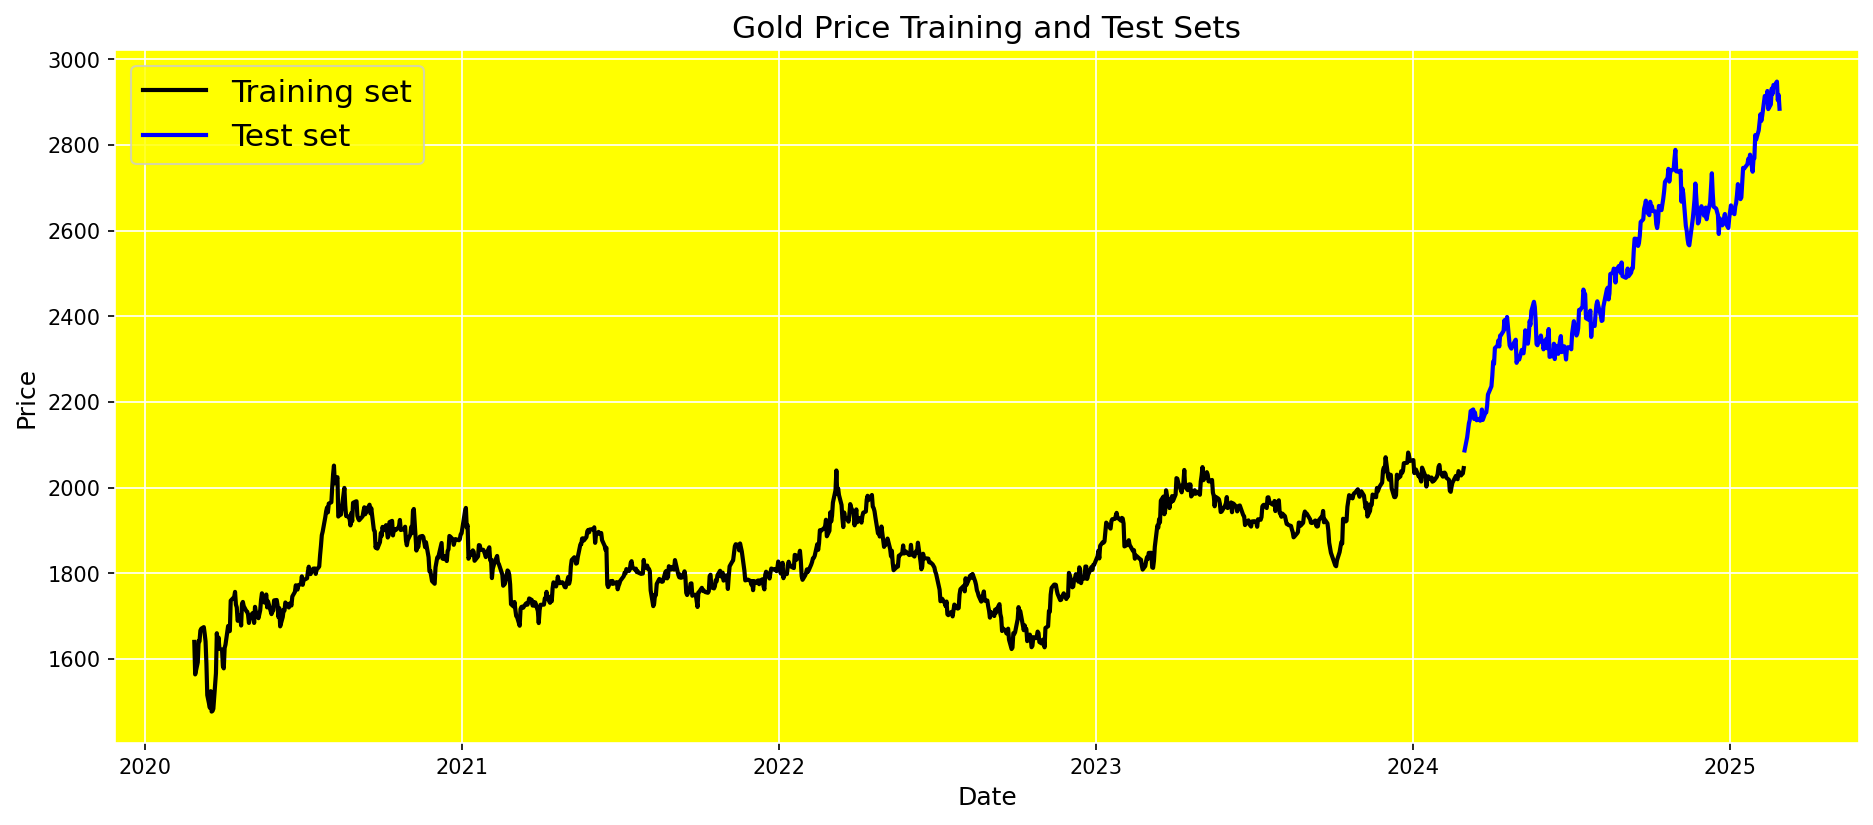

In [35]:
# In time series forecasting, we use the most recent data for testing.
# Here we consider the last year as the test set.
test_size = df[df.Date.dt.year == 2022].shape[0]
print("Test size (last year data):", test_size)

# Plot training and test set separation.
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes', edgecolor='white')
plt.plot(df.Date[:-test_size], df.Price[:-test_size], color='black', lw=2)
plt.plot(df.Date[-test_size:], df.Price[-test_size:], color='blue', lw=2)
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()


In [36]:
# We will predict Price based solely on historical Price data.
# Scale the Price using MinMaxScaler.
scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1, 1))

# Scale the Price column.
df['Scaled_Price'] = scaler.transform(df.Price.values.reshape(-1, 1))
print("Scaled Price Example:")
print(df[['Date', 'Price', 'Scaled_Price']].head())


Scaled Price Example:
                       Date        Price  Scaled_Price
0 2020-02-27 00:00:00-05:00  1640.000000      0.110635
1 2020-02-28 00:00:00-05:00  1564.099976      0.059023
2 2020-03-02 00:00:00-05:00  1592.300049      0.078199
3 2020-03-03 00:00:00-05:00  1642.099976      0.112063
4 2020-03-04 00:00:00-05:00  1641.099976      0.111383


In [37]:
# Define the window size (number of previous time steps used to predict the next time step).
window_size = 60

# Prepare training data: use all data except the test set.
train_data = df.Price[:-test_size]
train_data_scaled = scaler.transform(train_data.values.reshape(-1, 1))

X_train = []
y_train = []

for i in range(window_size, len(train_data_scaled)):
    X_train.append(train_data_scaled[i-window_size:i, 0])
    y_train.append(train_data_scaled[i, 0])

# Prepare test data: include an extra window to account for the sliding window.
test_data = df.Price[-test_size - window_size:]
test_data_scaled = scaler.transform(test_data.values.reshape(-1, 1))

X_test = []
y_test = []

for i in range(window_size, len(test_data_scaled)):
    X_test.append(test_data_scaled[i-window_size:i, 0])
    y_test.append(test_data_scaled[i, 0])

print("X_train Shape:", np.array(X_train).shape)
print("y_train Shape:", np.array(y_train).shape)
print("X_test Shape:", np.array(X_test).shape)
print("y_test Shape:", np.array(y_test).shape)


X_train Shape: (949, 60)
y_train Shape: (949,)
X_test Shape: (251, 60)
y_test Shape: (251,)


In [38]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Reshape X to be [samples, time steps, features].
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)


X_train Shape:  (949, 60, 1)
y_train Shape:  (949,)
X_test Shape:   (251, 60, 1)
y_test Shape:   (251,)


In [39]:
# We create an LSTM network with three layers.
# Define callbacks
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',  # Saves best model
    monitor='val_loss',        # Monitor validation loss
    save_best_only=True,       # Save only the best model
    mode='min',                # Minimize val_loss
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,               # Stop if no improvement for 10 epochs
    restore_best_weights=True, # Restore best weights after stopping
    verbose=1
)

def define_model():
    input_layer = Input(shape=(window_size, 1))
    x = LSTM(units=64, return_sequences=True)(input_layer)
    x = Dropout(0.2)(x)
    x = LSTM(units=64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units=64)(x)
    x = Dropout(0.2)(x)
    # A Dense layer with softmax activation is unusual for regression,
    # so we'll instead use a Dense layer with ReLU (or linear) activation.
    x = Dense(32, activation='relu')(x)
    output = Dense(1)(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()

    return model

# Define the model.
model = define_model()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 60, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 60, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 60, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model using the training set.
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, callbacks=[checkpoint_callback, early_stopping_callback], verbose=1)


In [41]:
# Evaluate the model on the test set.
result = model.evaluate(X_test, y_test)
print("Test Loss:", result)

# Predict the test set.
y_pred = model.predict(X_test)

# Compute Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred)
accuracy = 1 - mape
print("Test MAPE:", mape)
print("Test Accuracy:", accuracy)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012
Test Loss: 0.0017819706117734313


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step
Test MAPE: 0.04987242808826157
Test Accuracy: 0.9501275719117385


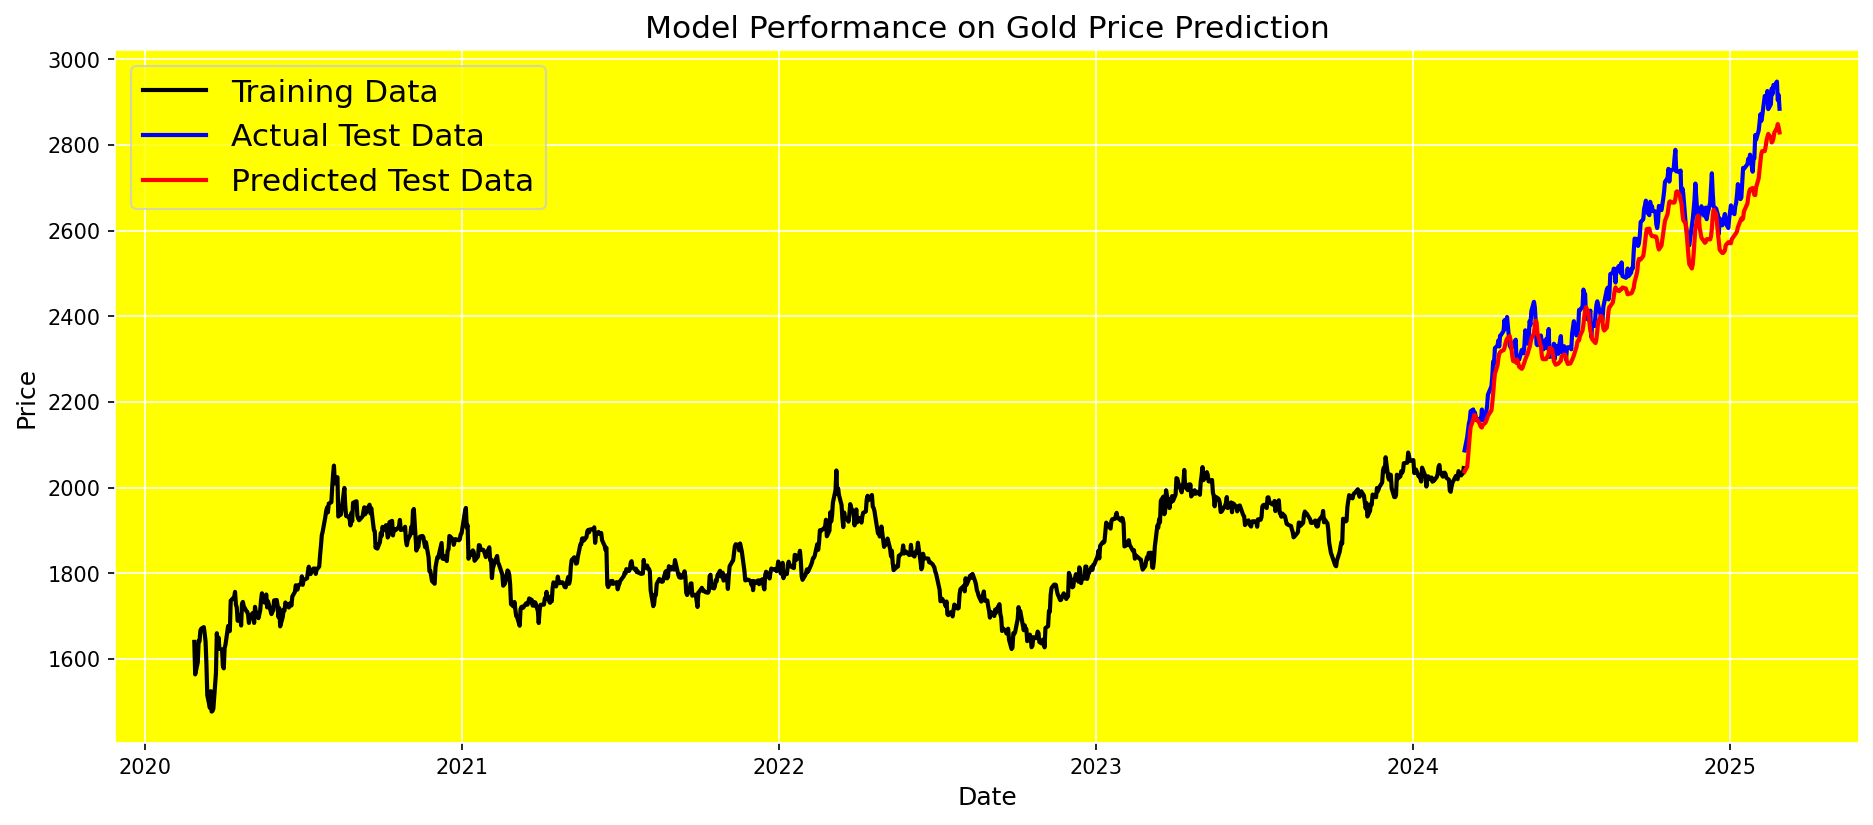

In [42]:
# Convert the scaled predictions and actual values back to original scale.
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_pred = scaler.inverse_transform(y_pred)

plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes', edgecolor='white')
# Plot the training data (up to the test set start)
plt.plot(df.Date[:-test_size], scaler.inverse_transform(train_data_scaled), color='black', lw=2)
# Plot actual test data and predicted test data
plt.plot(df.Date[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df.Date[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()


In [43]:
# Save the trained model for deployment.
load_model = model.save("best_model.keras")
